# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
import config
import evaluation_vectorization as ev
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device = 'cpu'
device

'cpu'

# Prepare data

## Dataset

In [5]:
if config.current_dataset is not None:
    ds = config.datasets[config.current_dataset]
else:
    ds = config.datasets[0]

ds

'VertebralColumn_c2'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets',
                        'dataset_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([310, 6]), torch.Size([310]), 310, 6, 2)

## Pseudo-electrical Signal

In [7]:
X = X - torch.min(X, axis=0)[0]
X = X / (torch.max(X, axis=0)[0])
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.3557, 0.5198, 0.2292, 0.2509, 0.3075, 0.0252],
        [0.1245, 0.2967, 0.0986, 0.1446, 0.4767, 0.0364],
        [0.4117, 0.5139, 0.3230, 0.3076, 0.3862, 0.0175],
        [0.4162, 0.5573, 0.2713, 0.2894, 0.3419, 0.0518],
        [0.2272, 0.2894, 0.1282, 0.2470, 0.4096, 0.0442],
        [0.1360, 0.3657, 0.0995, 0.1199, 0.6479, 0.0309],
        [0.2631, 0.4003, 0.2074, 0.2239, 0.5430, 0.0397],
        [0.1854, 0.3092, 0.1346, 0.1966, 0.5075, 0.0009],
        [0.1701, 0.3587, 0.2568, 0.1563, 0.5906, 0.0567],
        [0.1017, 0.2065, 0.2501, 0.1694, 0.1523, 0.0273]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(8192, int(E*train_rate))
E_test = min(2048, int(E*test_rate))
E_valid = min(2048, int(E*valid_rate))


random.seed(config.data_split_seed);
np.random.seed(config.data_split_seed);
torch.manual_seed(config.data_split_seed);

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(186, 62, 62)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Aging Aware PNN

In [11]:
random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

In [12]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, config.N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(config.N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, config.M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(config.K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [13]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [14]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=150, cache=ds)

  0%|          | 0/150 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.65274 | Loss: 1.291801095 |
| Epoch:     7 | Accuracy: 0.66105 | Loss: 0.915756762 |
| Epoch:    14 | Accuracy: 0.66129 | Loss: 0.824926078 |
| Epoch:    21 | Accuracy: 0.66129 | Loss: 0.875605762 |
| Epoch:    28 | Accuracy: 0.66177 | Loss: 0.816747725 |
| Epoch:    35 | Accuracy: 0.66153 | Loss: 0.802297652 |
| Epoch:    42 | Accuracy: 0.66129 | Loss: 0.766246319 |
| Epoch:    49 | Accuracy: 0.66129 | Loss: 0.727784991 |
| Epoch:    56 | Accuracy: 0.66129 | Loss: 0.704693317 |
| Epoch:    63 | Accuracy: 0.66129 | Loss: 0.700557768 |
| Epoch:    70 | Accuracy: 0.66129 | Loss: 0.717178822 |
| Epoch:    77 | Accuracy: 0.66129 | Loss: 0.697227657 |
| Epoch:    84 | Accuracy: 0.66129 | Loss: 0.736289203 |
| Epoch:    91 | Accuracy: 0.66129 | Loss: 0.695020854 |
| Epoch:    98 | Accuracy: 0.66129 | Loss: 0.714823246 |
| Epoch:   105 | Accuracy: 0.66129 | Loss: 0.685070813 |
| Epoch:   112 | Accuracy: 0.66129 | Loss: 0.705293596 |
| Epoch:   119 | Accuracy: 0.66

(95, 0.6629820466041565)

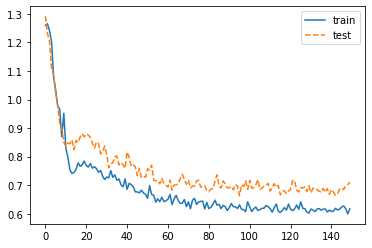

In [15]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [16]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_2)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.66129 | Loss: 0.748257518 |
| Epoch:    12 | Accuracy: 0.69129 | Loss: 0.644152105 |
| Epoch:    24 | Accuracy: 0.69016 | Loss: 0.603887558 |
| Epoch:    36 | Accuracy: 0.69089 | Loss: 0.564897716 |
| Epoch:    48 | Accuracy: 0.69677 | Loss: 0.539214075 |
| Epoch:    60 | Accuracy: 0.69524 | Loss: 0.530545294 |
| Epoch:    72 | Accuracy: 0.69774 | Loss: 0.515909851 |
| Epoch:    84 | Accuracy: 0.69500 | Loss: 0.532394648 |
| Epoch:    96 | Accuracy: 0.70323 | Loss: 0.521182477 |
| Epoch:   108 | Accuracy: 0.69750 | Loss: 0.530424714 |
| Epoch:   120 | Accuracy: 0.70677 | Loss: 0.521596968 |
| Epoch:   132 | Accuracy: 0.70161 | Loss: 0.497766942 |
| Epoch:   144 | Accuracy: 0.70621 | Loss: 0.510054946 |
| Epoch:   156 | Accuracy: 0.71427 | Loss: 0.504601777 |
| Epoch:   168 | Accuracy: 0.71621 | Loss: 0.499633700 |
| Epoch:   180 | Accuracy: 0.70871 | Loss: 0.508930504 |
| Epoch:   192 | Accuracy: 0.71081 | Loss: 0.491020024 |
| Epoch:   204 | Accuracy: 0.72

(239, 0.4470711350440979)

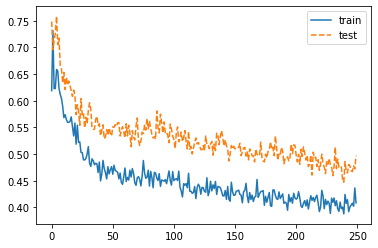

In [17]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [18]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=config.AAPNN_lr_3)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        config.m, config.T, config.M_train, config.K_train, config.M_test, config.K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=250, cache=ds)

  0%|          | 0/250 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.72508 | Loss: 0.482287705 |
| Epoch:    12 | Accuracy: 0.72823 | Loss: 0.492862284 |
| Epoch:    24 | Accuracy: 0.73032 | Loss: 0.457418531 |
| Epoch:    36 | Accuracy: 0.73782 | Loss: 0.455107629 |
| Epoch:    48 | Accuracy: 0.73274 | Loss: 0.449580222 |
| Epoch:    60 | Accuracy: 0.73113 | Loss: 0.485373467 |
| Epoch:    72 | Accuracy: 0.73355 | Loss: 0.469850600 |
| Epoch:    84 | Accuracy: 0.73500 | Loss: 0.466245949 |
| Epoch:    96 | Accuracy: 0.73798 | Loss: 0.473574996 |
| Epoch:   108 | Accuracy: 0.73782 | Loss: 0.476128846 |
| Epoch:   120 | Accuracy: 0.73484 | Loss: 0.472749621 |
| Epoch:   132 | Accuracy: 0.73944 | Loss: 0.455457777 |
| Epoch:   144 | Accuracy: 0.74040 | Loss: 0.460404038 |
| Epoch:   156 | Accuracy: 0.73274 | Loss: 0.483557612 |
| Epoch:   168 | Accuracy: 0.74242 | Loss: 0.458416462 |
| Epoch:   180 | Accuracy: 0.73750 | Loss: 0.443276495 |
| Epoch:   192 | Accuracy: 0.73960 | Loss: 0.451055974 |
| Epoch:   204 | Accuracy: 0.73

(247, 0.43716514110565186)

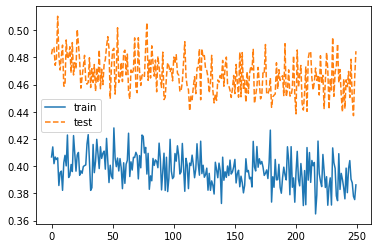

In [19]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [20]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)

# Evaluation

In [21]:
mean_acc_AAPNN, std_acc_AAPNN, mean_maa_AAPNN, std_maa_AAPNN = ev.Evaluation(AAPNN, valid_loader, config.M_valid, int(config.M_valid/10), config.K_valid, device)

  0%|          | 0/10 [00:00<?, ?it/s]

In [22]:
np.savetxt(f'./result/figures/{ds}_AAPNN_ACC_{seed}_{int(np.mean(mean_acc_AAPNN)*1000)}.txt', np.vstack((mean_acc_AAPNN, std_acc_AAPNN)))
np.savetxt(f'./result/figures/{ds}_AAPNN_MAA_{seed}_{int(np.mean(mean_maa_AAPNN)*1000)}.txt', np.vstack((mean_maa_AAPNN, std_maa_AAPNN)))